In [0]:
# Importar librerías necesarias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count, udf, isnan,avg
from pyspark import SparkFiles
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

In [0]:
# URL del dataset
url = "https://raw.githubusercontent.com/Kahsma/Proyecto_PDGE/refs/heads/main/Datos%20Limpios/ICFES_LIMPIO.csv"

spark.sparkContext.addFile(url)

In [0]:
df = spark.read.csv("file://"+SparkFiles.get("ICFES_LIMPIO.csv"),header = True, inferSchema = True)
# Seleccionar solo las columnas de interés
df_selected = df.select("PERCENTIL_LECTURA_CRITICA", "PERCENTIL_MATEMATICAS")
# Verificar correlación entre las variables
correlation_value = df_selected.corr("PERCENTIL_LECTURA_CRITICA", "PERCENTIL_MATEMATICAS")
print(f"Correlación entre las variables: {correlation_value}")

Correlación entre las variables: 0.7050074232042207


In [0]:
# Paso 1: Regresión Lineal usando Mínimos Cuadrados en PySpark
# Crear vector de características
assembler = VectorAssembler(inputCols=["PERCENTIL_LECTURA_CRITICA"], outputCol="features")
data = assembler.transform(df_selected).select("features", col("PERCENTIL_MATEMATICAS").alias("label"))

# Entrenar el modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(data)

# Obtener coeficientes y R^2
slope = lr_model.coefficients[0]
intercept = lr_model.intercept
r2_linear = lr_model.summary.r2

print(f"Ecuación de regresión lineal: y = {slope} * x + {intercept}")
print(f"R^2 (Regresión Lineal): {r2_linear}")


Ecuación de regresión lineal: y = 0.7041394974341076 * x + 14.885933790648508
R^2 (Regresión Lineal): 0.4970354667730629


In [0]:
# Paso 2: Regresión con K-Vecinos (KNN) usando scikit-learn
# Convertir DataFrame a Pandas para usar KNN
df_pandas = df_selected.toPandas()
X = df_pandas[['PERCENTIL_LECTURA_CRITICA']]
y = df_pandas['PERCENTIL_MATEMATICAS']

# Entrenar modelo KNN
start_knn = time.time()

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X, y)
y_pred_knn = knn.predict(X)
r2_knn = r2_score(y, y_pred_knn)

end_knn = time.time()

print(f"Modelo KNN(k=5): Aproximación de predicción con K-Vecinos")
print(f"R^2 (K-Vecinos): {r2_knn}")
print(f"Tiempo de procesamiento KNN: {end_knn - start_knn} segundos")


Modelo KNN(k=5): Aproximación de predicción con K-Vecinos
R^2 (K-Vecinos): 0.3924522612861353
Tiempo de procesamiento KNN: 21.70335340499878 segundos


In [0]:
# Paso 3: Clustering No Supervisado con K-Means
# Crear vector de características para K-Means
start_kmeans = time.time()
assembler_kmeans = VectorAssembler(inputCols=["PERCENTIL_LECTURA_CRITICA", "PERCENTIL_MATEMATICAS"], outputCol="features")
data_kmeans = assembler_kmeans.transform(df_selected)

# Entrenar modelo K-Means


kmeans = KMeans(featuresCol="features", k=4, seed=1)
kmeans_model = kmeans.fit(data_kmeans)

# Asignar clusters y calcular Silhouette Score
clusters_df = kmeans_model.transform(data_kmeans)
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
silhouette_score = evaluator.evaluate(clusters_df)

end_kmeans = time.time()
# Convertir resultados de K-Means a Pandas para visualización
print(f"Silhouette Score para K-Means: {silhouette_score}")
print(f"Tiempo de procesamiento K-Means: {end_kmeans - start_kmeans} segundos")

Silhouette Score para K-Means: 0.624196969073189
Tiempo de procesamiento K-Means: 18.973287105560303 segundos


In [0]:
# # Subplot 1: Diagrama de dispersión y regresión lineal
# plt.subplot(1, 3, 1)
# sns.scatterplot(data=df_pandas, x="PERCENTIL_LECTURA_CRITICA", y="PERCENTIL_MATEMATICAS", color="blue", label="Datos Originales")
# plt.plot(X, slope * X + intercept, color="red", label="Regresión Lineal")
# plt.plot(X, y_pred_knn, color="green", linestyle="--", label="K-Vecinos")
# plt.title("Diagrama de Dispersión con Regresión Lineal y KNN")
# plt.xlabel("PERCENTIL_LECTURA_CRITICA")
# plt.ylabel("PERCENTIL_MATEMATICAS")
# plt.legend()

# # Subplot 2: Diagrama de calor de correlación
# plt.subplot(1, 3, 2)
# correlation_matrix = df_pandas.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
# plt.title("Diagrama de Calor de Correlación")

# # Subplot 3: Diagrama de dispersión con agrupamiento K-Means
# plt.subplot(1, 3, 3)
# sns.scatterplot(data=clusters_pandas, x="PERCENTIL_LECTURA_CRITICA", y="PERCENTIL_MATEMATICAS", hue="prediction", palette="viridis")
# plt.title("Diagrama de Dispersión con Agrupamiento K-Means")
# plt.xlabel("PERCENTIL_LECTURA_CRITICA")
# plt.ylabel("PERCENTIL_MATEMATICAS")
# plt.legend(title="Cluster")

# # Mostrar todos los gráficos
# plt.tight_layout()
# plt.show()

# Paso 5: Tabla Comparativa de Modelos
comparison_df = pd.DataFrame({
    "Método": ["Regresión Lineal", "K-Vecinos", "Clustering K-Means"],
    "Ecuación": [f"y = {slope}*x + {intercept}", "Modelo KNN(k=5)", "No aplica"],
    "R^2": [r2_linear, r2_knn, "Silhouette"],
    "Puntaje/Calidad": [r2_linear, r2_knn, silhouette_score]
})

print("\nTabla Comparativa de Modelos")
print(comparison_df)


Tabla Comparativa de Modelos
               Método                                       Ecuación  \
0    Regresión Lineal  y = 0.7041394974341076*x + 14.885933790648508   
1           K-Vecinos                                Modelo KNN(k=5)   
2  Clustering K-Means                                      No aplica   

          R^2  Puntaje/Calidad  
0    0.497035         0.497035  
1    0.392452         0.392452  
2  Silhouette         0.624197  




### 1. **Regresión Lineal**:
   - **Ecuación del modelo**: La ecuación obtenida para la regresión lineal es \( y = 0.704 \cdot x + 14.886 \). Esto sugiere que por cada incremento de 1 en el percentil de lectura crítica, el percentil de matemáticas se incrementa en promedio alrededor de 0.704.
   - **R^2 (Coeficiente de determinación)**: El valor de \( R^2 = 0.497 \) indica que el modelo de regresión lineal explica aproximadamente el 49.7% de la variabilidad en los percentiles de matemáticas basándose en los percentiles de lectura crítica. Aunque el modelo capta una parte de la relación entre estas variables, el ajuste no es particularmente alto, lo que indica que otros factores no capturados por este modelo pueden influir en los resultados de matemáticas.

### 2. **K-Vecinos (KNN)**:
   - **Modelo**: El modelo KNN, configurado con \( k = 5 \) vecinos, tiene un **R^2 de 0.392**, lo que indica que explica el 39.2% de la variabilidad en los percentiles de matemáticas. Esto es menor que el ajuste de la regresión lineal.
   - **Interpretación**: Aunque KNN es flexible y puede modelar relaciones no lineales, el valor de \( R^2 \) sugiere que la relación entre los percentiles no se ajusta bien a este enfoque en comparación con la regresión lineal. Esto puede ser porque KNN suele funcionar mejor con más datos y con relaciones complejas, mientras que aquí parece que la relación es algo más lineal.

### 3. **Clustering K-Means**:
   - **Índice de Silhouette**: El puntaje de Silhouette de **0.624** indica una separación razonable entre los clusters, ya que se considera que valores de Silhouette entre 0.5 y 1 reflejan una buena cohesión interna de los clusters y una buena separación entre ellos.
   - **Interpretación**: La agrupación muestra que existen patrones o agrupaciones naturales en los datos que el modelo K-Means logra identificar. Esto sugiere que dentro de los datos de percentiles de lectura crítica y matemáticas, se pueden identificar grupos con características similares. Estos clusters podrían representar diferentes grupos de estudiantes en función de sus habilidades en ambas áreas, lo que podría ser útil para análisis adicionales o intervenciones educativas.

### Conclusión General:
- La **regresión lineal** tiene un ajuste moderado, con un \( R^2 \) mayor al de KNN, lo que indica una relación lineal moderada entre los percentiles de lectura crítica y de matemáticas. Sin embargo, el ajuste aún es bajo, por lo que esta relación lineal no explica completamente las variaciones en el rendimiento en matemáticas.
- El **KNN** no ofrece un ajuste mejor que la regresión lineal, probablemente porque la relación no es tan compleja o no lineal como para que KNN aporte un mayor valor en este caso.
- El **clustering K-Means** revela grupos de estudiantes con características similares en ambos percentiles, lo cual puede ser útil para segmentar y analizar subgrupos dentro de la población estudiada, sugiriendo que podrían existir diferentes niveles de rendimiento o perfiles de estudiantes.

En resumen, el análisis sugiere que:
1. Existe una relación lineal moderada entre los percentiles de lectura crítica y matemáticas, aunque hay otros factores que también pueden influir en el rendimiento de matemáticas.
2. El clustering puede ser útil para identificar grupos de estudiantes y comprender mejor sus perfiles, lo que podría orientar intervenciones personalizadas.

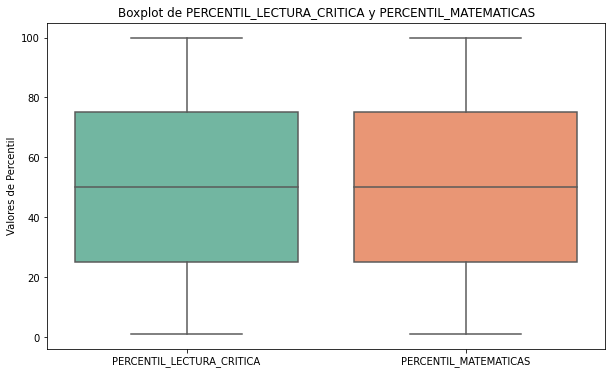

In [0]:

# Paso 7: Boxplot para verificar la distribución
plt.figure(figsize=(10, 6))

# Boxplot de ambas columnas
sns.boxplot(data=df_pandas[['PERCENTIL_LECTURA_CRITICA', 'PERCENTIL_MATEMATICAS']], palette='Set2')
plt.title("Boxplot de PERCENTIL_LECTURA_CRITICA y PERCENTIL_MATEMATICAS")
plt.ylabel("Valores de Percentil")
plt.show()


# Justificacion Columanas
Se hace uso de las columnas de PERCENTIL_LECTURA_CRITICA Y PERCENTIL_MATEMATICAS para ver si por ejemplo que sucede con la nota de uno con respectod a la otra. Esto para ver la relación qeu se tienen. Esto despues puede ser mirado desde municipio y con esta info se podria relacionar con los ddiferentes indices. este seria el paso inicial

# Modelos Escogidos

La elección de los métodos KNN y K-Means en este análisis se justifica en función de sus propiedades y la naturaleza de los datos de los percentiles en lectura crítica y matemáticas. A continuación, se detallan las razones para utilizar cada uno de estos métodos:

### 1. **K-Vecinos más Cercanos (KNN)**
   - **Propósito**: KNN se utiliza aquí como un método de **regresión no lineal** para estimar la relación entre el percentil de lectura crítica y el percentil de matemáticas. Su función es predecir valores continuos (en este caso, percentiles de matemáticas) basándose en los valores de características de observaciones vecinas.
   - **Flexibilidad**: A diferencia de la regresión lineal, que solo capta relaciones lineales, KNN permite modelar relaciones más complejas y potencialmente no lineales entre las variables. Aunque la relación entre estos percentiles parece lineal, KNN ayuda a verificar si hay alguna complejidad adicional que la regresión lineal no detecta.
   - **Interpretación directa**: En el contexto de los datos educativos, KNN puede ofrecer una interpretación intuitiva: predice el rendimiento en matemáticas de un estudiante basándose en el rendimiento de sus "vecinos" con puntajes de lectura crítica similares. Esto es útil en contextos donde se espera que el rendimiento académico tenga cierta relación entre habilidades, sin asumir necesariamente una relación estrictamente lineal.
   - **Comparación de modelos**: KNN permite evaluar si la relación entre los percentiles de lectura y matemáticas es verdaderamente lineal (en cuyo caso, la regresión lineal debería funcionar mejor) o si existen relaciones no lineales que KNN puede capturar mejor.

### 2. **Clustering K-Means**
   - **Propósito**: K-Means es un método de **agrupamiento no supervisado** que organiza los datos en grupos basados en similitudes. Aquí, K-Means se aplica para descubrir patrones o "perfiles" de estudiantes en función de sus puntajes en lectura crítica y matemáticas.
   - **Identificación de subgrupos**: En el contexto educativo, los estudiantes pueden tener diferentes niveles de habilidades en lectura crítica y matemáticas. El uso de K-Means permite identificar estos subgrupos o perfiles de estudiantes, lo que puede ser útil para intervenciones específicas (por ejemplo, estudiantes fuertes en lectura pero con dificultades en matemáticas, o viceversa).
   - **Mejora del análisis descriptivo**: La formación de clusters ayuda a interpretar mejor los datos al mostrar si existen agrupaciones naturales entre los estudiantes. Esto puede reflejar patrones de rendimiento que no son evidentes con una regresión.
   - **Guía para políticas educativas**: Los resultados del clustering pueden sugerir grupos que requieran diferentes estrategias educativas o recursos. Por ejemplo, los clusters pueden señalar a los estudiantes con fortalezas y debilidades específicas, permitiendo la implementación de políticas o programas de apoyo más personalizados.

### Justificación Global
Al combinar **KNN** y **K-Means** en este análisis, se obtiene una perspectiva amplia de los datos:
- **KNN** verifica la relación entre los percentiles como un modelo predictivo y evalúa si la relación es lineal o tiene una complejidad adicional.
- **K-Means** descubre patrones internos en el conjunto de datos, revelando perfiles de estudiantes que podrían no ser captados en un modelo de predicción.

En resumen, **KNN** y **K-Means** proporcionan herramientas complementarias: KNN explora la capacidad de predicción y relación entre variables, mientras que K-Means descubre agrupaciones y patrones internos que pueden ser útiles para políticas educativas o intervenciones específicas.

# Justificación de Correlación, datos atipicos y Correlación
Como se esta usando los percentiles estos ya estan normalziados y como se ve en el grafico de boxplot no  see estan tomando datos atipicos y se usa la regrecion lineal  de minimos cuadrados para la correlación

# Comparación Databricks vs Cluster

## Databricks

KNN -> 21.70335340499878 segundos

K-Means -> 18.973287105560303 segundos

## Cluster del  grupo 

KNN -> 15.28296947479248 segundos

K-Means -> 9.798679828643799 segundos

## Nuestro  Cluster 

Cores in use: 16 Total, 16 Used
Memory in use: 41.6 GiB Total, 4.0 GiB Used
Resources in use:
Applications: 1 Running, 75 Completed
Drivers: 0 Running, 0 Completed
Status: ALIVE



